# Coalition-Finding Algorithmus

Dieses Notebook demonstriert die Nutzung des Algorithmus `subset_finding`, um Koalitionen von Features mit dem höchsten bzw. niedrigsten aggregierten Interaktionswert zu identifizieren.

Als Grundlage dienen Interaktionswerte, die auf einem erklärbaren Modell basieren und mit Hilfe von Indizes wie `k-SII`, `STII` oder `FSII` berechnet wurden.

Der zugrundeliegende Algorithmus basiert auf einem heuristischen Beam Search, der durch gezielte Vorauswahl vielversprechende Teilkoalitionen eine effiziente Suche in großen Feature-Räumen ermöglicht.





## Vorbereitung: Imports

Wir beginnen mit dem Import aller relevanten Module für die Modellierung und die Datenaufbereitung.



In [1]:
#Modell-Erklärbarkeit mit shapiq
import shapiq
from shapiq.plot.si_graph import si_graph_plot
from shapiq import load_bike_sharing
from shapiq import Explainer

# Scikit-Learn: Datenaufbereitung und Modelle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Datensatz und Regressionsmodell

In diesem Beispiel verwenden wir den `bike_sharing`-Datensatz, der stündliche Fahrradverleihzahlen und zugehörige Kontextinformationen wie Temperatur, Luftfeuchtigkeit oder Uhrzeit enthält.

Wir trainieren ein Regressionsmodell, das die Ausleihzahl vorhersagt. Standardmäßig verwenden wir hier einen Random Forest Regressor – andere Alternativen wären z. B. `LinearRegression`, `KNeighborsRegressor` oder `DecisionTreeRegressor`.

Anschließend berechnen wir Interaktionswerte mithilfe des `k-SII`-Index.
Diese Werte dienen als Grundlage für die nachfolgende Koalitionsanalyse.


In [2]:
# DataFrame laden (für Spaltennamen + Bearbeitung)
X_df, y_df = load_bike_sharing(to_numpy=False)

# Spaltennamen für readable-Funktion sichern
column_names = list(X_df.columns)

# In NumPy-Array umwandeln für Modell & Explainer
X = X_df.to_numpy()
y = y_df.to_numpy()

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Modelltraining
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Anzeige der ersten 10 Zeilen
print(X_df.head(10))

       hour    temp  feel_temp  humidity  windspeed  year  month  holiday  \
0 -1.000000 -0.8125  -0.683918  0.600000  -1.300268  -1.0   -1.0      0.0   
1 -0.916667 -0.8750  -0.736714  0.566667  -1.300268  -1.0   -1.0      0.0   
2 -0.833333 -0.8750  -0.736714  0.566667  -1.300268  -1.0   -1.0      0.0   
3 -0.750000 -0.8125  -0.683918  0.400000  -1.300268  -1.0   -1.0      0.0   
4 -0.666667 -0.8125  -0.683918  0.400000  -1.300268  -1.0   -1.0      0.0   
5 -0.583333 -0.8125  -0.789163  0.400000  -0.699732  -1.0   -1.0      0.0   
6 -0.500000 -0.8750  -0.736714  0.566667  -1.300268  -1.0   -1.0      0.0   
7 -0.416667 -0.9375  -0.789163  0.766667  -1.300268  -1.0   -1.0      0.0   
8 -0.333333 -0.8125  -0.683918  0.400000  -1.300268  -1.0   -1.0      0.0   
9 -0.250000 -0.5625  -0.473428  0.433333  -1.300268  -1.0   -1.0      0.0   

   weekday  workingday  season  weather  
0     0.75        -1.0     1.0      0.0  
1     0.75        -1.0     1.0      0.0  
2     0.75        -1.0    

## Interaktionswerte berechnen

Um sinnvolle Koalitionen identifizieren zu können, benötigen wir sogenannte Interaktionswerte.
Diese quantifizieren den Beitrag einzelner oder kombinierter Features zur Vorhersage eines Modells.

Wir verwenden dazu den `Explainer` aus der `shapiq`-Bibliothek mit dem Index `k-SII` (Shapley Interaction Index).
Dabei legen wir die maximale Interaktionsordnung (`max_order`) auf 3 fest – d. h. es werden Einzel-, Paar- und Dreifachinteraktionen berücksichtigt.

Die Erklärung erfolgt für einen einzelnen Datenpunkt aus dem Trainingsdatensatz.


In [3]:
# Initilisieren des Explainer mit dem trainierten Modell
explainer = Explainer(
    model=model.predict,
    data=X_train,
    index="k-SII",
    max_order=3
)

# Erklärung berechenen für den ersten Trainingspunkt
x0 = X_train[0]
explanation = explainer.explain(x0, budget=1024)

# Ausgabe der Feature-Namen
print("Namen der Features: ", column_names)

# Ausgabe der erklärten Interaktionen
print(explanation)

Namen der Features:  ['hour', 'temp', 'feel_temp', 'humidity', 'windspeed', 'year', 'month', 'holiday', 'weekday', 'workingday', 'season', 'weather']
InteractionValues(
    index=k-SII, max_order=3, min_order=0, estimated=True, estimation_budget=1024,
    n_players=12, baseline_value=190.86463629737608,
    Top 10 interactions:
        (): 190.86463629737608
        (0,): 58.37736379608407
        (8,): 43.64613777508325
        (3,): 38.47510432725105
        (10,): 34.83849206783698
        (4,): 32.93809351194602
        (7,): 32.35946741646475
        (0, 8): -32.427230688442286
        (0, 9): -35.469920622409965
        (0, 1): -44.567613210674274
)


## Koalitionsfindung mit Beam Search (Theorie)

Der Algorithmus `subset_finding` nutzt eine heuristische Beam Search zur effizienten Koalitionssuche.

Ziel ist es, unter allen möglichen Koalitionen der Größe $l$ diejenigen zu finden, die den höchsten oder niedrigsten Gesamtbeitrag zur Vorhersage eines Modells leisten – gemessen an den sogenannten Interaktionswerten. Dabei bezeichnen wir mit $S_\text{max}$ die Koalition der Größe $l$, die den höchsten aggregierten Interaktionswert erzielt, und mit $S_\text{min}$ diejenige mit dem niedrigsten.


### Wie wird eine Koalition bewertet?

Jede Koalition $S$ besteht aus einer Teilmenge von Features, z. B. $S = \{A, B\}$.
Zur Bewertung wird der gesamte Einfluss dieser Feature-Kombination auf das Modell aggregiert:


$$
\hat{\nu}_e(S) = e_0 + \sum_{i \in S} e_{\{i\}} + \sum_{\substack{i,j \in S \\ i < j}} e_{\{i,j\}} + \sum_{\substack{T \subseteq S \\ |T| > 2}} e_T
$$

Dabei gilt:
- $e_0$: Basiswert ohne Features (leere Koalition)
- $e_{\{i\}}$: Beitrag des einzelnen Features $i$
- $e_{\{i,j\}}$: Beitrag des Zusammenspiels von zwei Features
- $e_T$: höherwertige Interaktionen (drei oder mehr)

Je höher der Wert $\hat{\nu}_e(S)$, desto stärker der Einfluss der Koalition auf die Vorhersage (positiv oder negativ).

### Beispiel

Gegeben sei eine Feature-Menge $N = \{A, B, C\}$ mit folgenden Interaktionen:

- $e_{\{A\}} = 1.0$, $e_{\{B\}} = -0.5$, $e_{\{A,B\}} = 0.3$, $e_0 = 0.0$
- $e_{\{C,B\}} = -0.2$, $e_{\{C\}} = -0.1$, $e_{\{A,C\}} = 0.2$, $e_{\{A,B,C\}} = 0.6$

Dann ergibt sich für die Koalition $S = \{A, B\}$:

$$
\hat{\nu}_e(\{A,B\}) = 0.0 + 1.0 - 0.5 + 0.3 = 0.8
$$

### Wie findet der Algorithmus solche Koalitionen effizient?

Statt alle möglichen Kombinationen zu prüfen, was bei vielen Features sehr aufwändig wäre, geht der Algorithmus schrittweise vor:

- Zuerst werden alle einzelnen Features als Startpunkte betrachtet
- In mehreren Runden werden die vielversprechendsten Kandidaten um je ein weiteres Feature erweitert
- In jeder Runde bleiben nur die am besten bewerteten Kombinationen erhalten, alle anderen werden verworfen

Der Algorithmus besteht dabei aus zwei klar getrennten Phasen:

1. **Approximationsphase**:
   In dieser Phase erfolgt die Bewertung der Koalitionen heuristisch.
   Höherwertige Interaktionen werden vorab anteilig auf die Einzelspieler verteilt.
   So kann der Algorithmus Koalitionen effizient vergleichen, ohne die vollständige Formel auszuwerten.

2. **Genauigkeitsphase**:
   Sobald die Anzahl der Kandidaten unter eine festgelegte Schwelle sinkt (die sogenannte Threshold-Beam-Breite),
   wird die Bewertung auf Basis der exakten Bewertungsfunktion durchgeführt – also unter Berücksichtigung aller vorhandenen Hyperkanten.

Auf diese Weise lassen sich Koalitionen mit extremen Interaktionswerten effizient und präzise identifizieren.



## Koalitionsfindung mit Beam Search (Anwendung)

Wir wenden nun den Algorithmus `subset_finding` auf die berechneten Interaktionswerte an.
Gesucht wird eine Koalition fester Größe (hier: $l = 3$) mit maximalem bzw. minimalem aggregierten Interaktionswert gemäß der zuvor erklärten Bewertungsfunktion.

### Parameter von `subset_finding`:

Die Funktion `subset_finding(...)` ist der zentrale Einstiegspunkt für die Koalitionsanalyse mittels Beam Search. Im Folgenden erläutern wir die beiden wichtigsten Parameter im Kontext unseres Beispiels:

- **`interaction_values:`**
  Das `InteractionValues`-Objekt (hier `explanation`) enthält die erklärten Interaktionen des Modells für einen bestimmten Datenpunkt (`x0`). Diese wurden in unserem Beispiel zuvor mit dem `Explainer` aus der Bibliothek `shapiq` berechnet – unter Verwendung des `k-SII`-Indexes und einer maximalen Interaktionsordnung von 3. Das Objekt fasst alle Einzel-, Paar- und Dreifachinteraktionen zusammen und bildet somit die Bewertungsgrundlage für jede mögliche Koalition von Features.

- **`max_size:`**
  Dieser Parameter legt die gewünschte Koalitionsgröße `l` fest, d. h. wie viele Features in den gesuchten Koalitionen enthalten sein sollen. In unserem Beispiel setzen wir `max_size=3`, um gezielt Dreierkombinationen zu analysieren. Das entspricht typischen Anwendungsfällen, in denen wir kompakte Gruppen von stark interagierenden Features identifizieren möchten. Dabei gilt: `max_size` muss eine ganze Zahl im Bereich $ 0 \leq l \leq |N| $ sein, wobei $ l $ die gewünschte Koalitionsgröße und $ |N| $ die Anzahl der Spieler (Features) bezeichnet. Negative Werte oder Koalitionsgrößen größer als die Gesamtanzahl der Features sind nicht zulässig.

**Raises:**

- `TypeError` – Wenn `max_size` kein Integer ist.
- `ValueError` – Wenn `max_size` negativ ist oder größer als die Anzahl der Spieler (`n_players`) im `InteractionValues`-Objekt.



In [4]:
# Import des Koalitionsfindungs-Algorithmus
from shapiq_student.subset_finding import subset_finding

# Suche nach Koalitionen der Größe 3
beam_result = subset_finding(interaction_values=explanation, max_size=3)
beam_result

InteractionValues(
    index=k-SII, max_order=3, min_order=3, estimated=True, estimation_budget=None,
    n_players=12, baseline_value=190.86463629737608
)

## Analyse der gefundenen Koalitionen

Die Funktion `subset_finding` liefert zwei Koalitionen:

- `s_max`: Die Koalition der Größe `l` (bzw. `max_size`), die den höchsten aggregierten Interaktionswert erzielt
- `s_min`: Die Koalition der Größe `l` (bzw. `max_size`), die den niedrigsten aggregierten Interaktionswert erzielt

Zusätzlich gibt sie auch die zugehörigen aggregierten Interaktionswerte `v_max` und `v_min` zurück.

Im Folgenden untersuchen wir die Koalitionen genauer – sowohl in numerischer Form (Index) als auch lesbar mit Spaltennamen.


In [5]:
# Rohausgabe
print("Koalition mit höchstem, aggregierten Interaktionswert (Index):", beam_result.s_max)
print("Koalition mit niedrigstem, aggregierten Interaktionswert (Index):", beam_result.s_min)
print("Interaktionswert der Koalition mit höchstem, aggregierten Interaktionswert:", beam_result.v_max)
print("Interaktionswert der Koalition mit niedrigstem, aggregierten Interaktionswert:", beam_result.v_min)

# Spaltennamen aus dem ursprünglichen DataFrame laden (X_df stammt von oben)
column_names = list(X_df.columns)


# Funktion für lesbare Koalitionsdarstellung
def readable(S: set[int]) -> set[str]:
    return {column_names[i] for i in set(S)}


# Anzeige der Koalitionen in lesbarer Form
print("Koalition mit höchstem, aggregierten Interaktionswert (Namen):", readable(beam_result.s_max))
print("Koalition mit niedrigstem, aggregierten Interaktionswert (Namen):", readable(beam_result.s_min))

Koalition mit höchstem, aggregierten Interaktionswert (Index): {0, 10, 3}
Koalition mit niedrigstem, aggregierten Interaktionswert (Index): {1, 2, 9}
Interaktionswert der Koalition mit höchstem, aggregierten Interaktionswert: 296.7587671201911
Interaktionswert der Koalition mit niedrigstem, aggregierten Interaktionswert: 140.0003736407298
Koalition mit höchstem, aggregierten Interaktionswert (Namen): {'humidity', 'season', 'hour'}
Koalition mit niedrigstem, aggregierten Interaktionswert (Namen): {'workingday', 'feel_temp', 'temp'}


### Alternative: Direkter Zugriff auf Koalitionswerte über Lookup-Dictionary

Neben den Attributen `s_max`, `s_min`, `v_max` und `v_min` können die in `InteractionValues` gespeicherten Koalitionen und deren aggregierte Interaktionswerte auch direkt über das Lookup-Dictionary ausgelesen werden.

Das Attribut `interaction_lookup` enthält dabei ein Mapping von Koalitions-Tupeln (z. B. `(2, 5, 9)`) auf Integer-Indizes, die mit dem `values`-Array korrespondieren.

So lassen sich alle gespeicherten Koalitionen mit ihren Werten z. B. programmgesteuert iterieren, visualisieren oder in Berichten weiterverarbeiten.

>Hinweis: Das von `subset_finding(...)` zurückgegebene `InteractionValues`-Objekt enthält genau zwei Koalitionen:
>
> - Die Koalition mit dem niedrigsten aggregierten Interaktionswert (`s_min`) befindet sich immer an Index 0 im `.values`-Array
> - Die Koalition mit dem höchsten aggregierten Interaktionswert (`s_max`) befindet sich immer an Index 1 im `.values`-Array
>
> Diese Positionen sind konsistent und durch das interne `interaction_lookup` eindeutig nachvollziehbar.
> Sie erlauben es, direkt auf die Extrem-Koalitionen zuzugreifen – entweder über die Attribute `s_min`, `s_max` oder über die Positionsindizes `0` und `1`.

In [6]:
# Zugriff auf Koalitionen und zugehörige Werte aus dem Ergebnisobjekt
lookup = beam_result.interaction_lookup
values = beam_result.values

# Ermitteln der Koalitions-Tupel anhand ihrer bekannten Position im Ergebnisarray
s_min_key = next(k for k, v in lookup.items() if v == 0)
s_max_key = next(k for k, v in lookup.items() if v == 1)

# Umwandlung der Koalition in lesbare Spaltennamen (sortiert nach Feature-Index)
s_min_names = readable(set(s_min_key))
s_max_names = readable(set(s_max_key))

# Ausgabe der Koalitionen mit Namen und zugehörigem aggregierten Interaktionswert
print(f"Koalition (s_max) {s_max_names} → Interaktionswert: {values[1]:.3f}")
print(f"Koalition (s_min) {s_min_names} → Interaktionswert: {values[0]:.3f}")


Koalition (s_max) {'humidity', 'season', 'hour'} → Interaktionswert: 296.759
Koalition (s_min) {'workingday', 'feel_temp', 'temp'} → Interaktionswert: 140.000


## Visualisierung der Koalitionsstrukturen und Interaktionen

Der folgende Netzwerkplot visualisiert die Interaktionen der Ordnung 1 bis 3 für den betrachteten Datenpunkt.
Besonders hervorgehoben sind dabei die Spieler (Features), die Teil der zuvor bestimmten Koalitionen `s_max` und `s_min` mit Koalitionsgröße $l=3$ sind:

- Koalition s_max: {'windspeed', 'hour', 'humidity'}
  → Aggregierter Interaktionswert: 282.441
- Koalition s_min: {'temp', 'workingday', 'feel_temp'}
  → Aggregierter Interaktionswert: 132.399

Im Plot zeigt sich, dass die `s_max`-Features deutlich zu den stärksten positiven Einzelbeiträgen (Ordnung 1) gehören – erkennbar an ihren leuchtend roten Knoten.
Zusätzlich bestehen zwischen ihnen mehrere positive Interaktionen der Ordnung 2 und 3 (rote Kanten), was die starke aggregierte Wirkung dieser Koalition unterstreicht.

Im Gegensatz dazu umfasst die `s_min`-Koalition mit `temp` den deutlich negativsten Einzelspieler, sowie zwei der schwächsten positiven Einzelspieler.
Obwohl es mit `year` noch einen weiteren negativen Spieler im Netzwerk gibt, ist dieser nicht automatisch geeigneter für `s_min`, da der Plot auch zeigt, dass zwischen den gewählten `s_min`-Spielern deutlich negative Interaktionen höherer Ordnung (blau eingefärbte Kanten) bestehen.
Dies stützt die Wahl dieser Koalition als tatsächlich minimal in Bezug auf den aggregierten Interaktionswert.

Weitere Details zum `network_plot()` finden sich in der API-Dokumentation von `shapiq`:
https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot

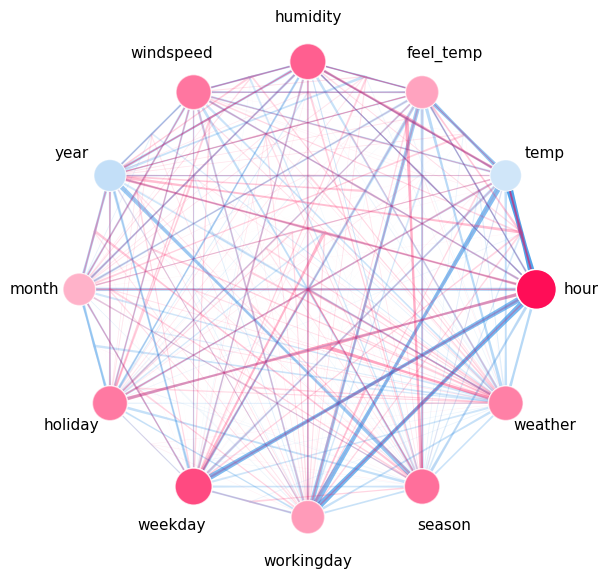

In [7]:
si_graph_plot(
    interaction_values=explanation,
    feature_names=X_df.columns,
    min_max_order=(1, 3),
    show=True
)


Zur weiteren Untermauerung des Netzwerkplots zeigt der folgende Balkenplot die Einzelinteraktionen (Ordnung 1) der Spieler aus `s_max` und `s_min`.

Wie zu erwarten, zeigen die `s_max`-Features die höchsten positiven Einzelbeiträge, während die `s_min`-Features entweder nur schwach positiv oder sogar negativ wirken.

Weitere Informationen zur Funktion `stacked_bar_plot()` finden sich in der offiziellen Dokumentation:
https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot

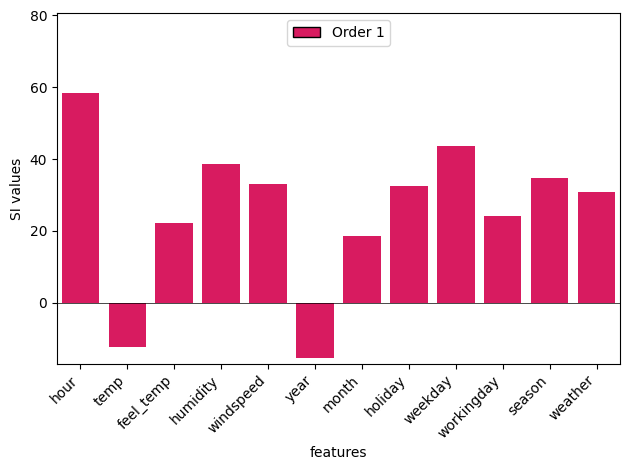

In [8]:
shapiq.stacked_bar_plot(
    interaction_values=explanation.get_n_order(1),
    feature_names=X_df.columns,
    show=True,
)

## Fazit

Der heuristische Beam Search Algorithmus ermöglicht eine effiziente Identifikation von Koalitionen mit hohem oder niedrigem Einfluss auf eine Modellvorhersage – selbst bei großen Feature-Mengen.

Durch die Kombination aus Approximations- und Genauigkeitsphase werden vielversprechende Koalitionen gezielt ausgewählt und präzise bewertet.
So lässt sich eine starke Reduktion des Suchraums erzielen, ohne auf gute Lösungen verzichten zu müssen.

Der Algorithmus lässt sich flexibel auf Interaktionen höherer Ordnung anwenden und stellt eine leistungsfähige Erweiterung
zur Analyse  von modellbasierten Erklärungen dar.
